In [1]:
import matplotlib
%matplotlib qt
import scipy
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from scipy import signal, misc
from skimage import io
import numpy as np
from PIL import Image
import cv2
from scipy.spatial import Delaunay
import skimage.draw
from skimage.draw import polygon_perimeter, polygon

In [2]:
im1 = io.imread('grandpa.jpeg')/255.
im2 = io.imread('obama.jpeg')/255.

In [3]:
def point_selector(im, total):
    plt.imshow(im)
    im_points = []
    for i in np.arange(total):
        point = plt.ginput(1, timeout = 0, show_clicks=True)
        plt.scatter(point[0][0], point[0][1])
        plt.draw()
        im_points.append([point[0][1], point[0][0]])
    plt.close()
    corners = [[0, 0], [0, im.shape[1] - 1], [im.shape[0] - 1, 0], [im.shape[0] - 1, im.shape[1] - 1]]
    im_points.extend(corners)
    return np.array(im_points)

def triangles(points):
    return Delaunay(np.array(points)).simplices

In [ ]:
im1_points = point_selector(im1, 30)
print(im1_points)

# result that I got from my 30 pts.
# np.array([[ 93.23106061,  36.375],
#  [ 42.85227273,  53.60984848],
#  [ 20.97727273, 100.67424242],
#  [ 42.18939394, 150.39015152],
#  [ 79.31060606, 165.63636364],
#  [117.09469697, 180.88257576],
#  [160.18181818, 174.91666667],
#  [186.6969697,159.00757576],
#  [223.15530303, 140.4469697 ],
#  [239.06439394, 100.01136364],
#  [219.1780303,   59.57575758],
#  [189.34848485,  40.35227273],
#  [160.18181818,  32.39772727],
#  [125.71212121,  26.43181818],
#  [188.68560606,  72.83333333],
#  [190.01136364, 100.01136364],
#  [190.01136364, 127.18939394],
#  [114.44318182,  52.9469697 ],
#  [107.15151515,  66.86742424],
#  [115.10606061,  84.10227273],
#  [117.75757576,  69.51893939],
#  [115.10606061, 118.5719697 ],
#  [106.48863636, 137.79545455],
#  [116.43181818, 150.39015152],
#  [121.0719697, 137.13257576],
#  [156.86742424,  85.4280303 ],
#  [161.50757576, 101.33712121],
#  [159.51893939, 115.92045455],
#  [139.63257576, 87.41666667],
#  [139.63257576, 111.28030303],
#  [  0.,           0.        ],
#  [  0.,         204.        ],
#  [244.,           0.        ],
#  [244.,         204.        ]])

In [ ]:
im2_points = point_selector(im2, 30)
print(im2_points)

# result that I got from my 30 pts.
# np.array([[ 83.62987013,  32.11363636],
#  [ 44.36038961,  47.42207792],
#  [ 20.39935065,  95.34415584],
#  [ 47.68831169, 163.89935065],
#  [ 90.28571429, 172.55194805],
#  [108.25649351, 187.86038961],
#  [159.50649351, 178.54220779],
#  [188.79220779, 159.90584416],
#  [217.41233766, 138.60714286],
#  [235.38311688, 101.33441558],
#  [219.40909091,  63.3961039 ],
#  [192.78571429,  44.75974026],
#  [158.84090909,  26.78896104],
#  [115.57792208,  10.81493506],
#  [176.1461039,  66.72402597],
#  [176.81168831, 102.66558442],
#  [176.81168831, 133.94805195],
#  [100.26948052,  52.08116883],
#  [ 90.9512987,   70.05194805],
#  [ 98.93831169,  86.69155844],
#  [102.93181818,  70.71753247],
#  [ 98.27272727, 127.95779221],
#  [ 92.94805195, 141.93506494],
#  [101.60064935, 155.91233766],
#  [104.26298701, 141.26948052],
#  [142.2012987,  107.32467532],
#  [142.2012987,   78.03896104],
#  [142.2012987,  130.62012987],
#  [122.89935065,  92.68181818],
#  [122.89935065, 121.96753247],
#  [  0.,           0.        ],
#  [  0.,         204.        ],
#  [245.,           0.        ],
#  [245.,         204.        ]])


In [ ]:
im1_tris = triangles(im1_points)
im2_tris = triangles(im2_points)

In [ ]:
def compute(tri1,tri2):
    x = np.linalg.solve([[tri1[0][0],tri1[0][1],1,0,0,0],[0,0,0,tri1[0][0],tri1[0][1],1],
        [tri1[1][0],tri1[1][1],1,0,0,0],[0,0,0,tri1[1][0],tri1[1][1],1],
        [tri1[2][0],tri1[2][1],1,0,0,0],[0,0,0,tri1[2][0],tri1[2][1],1]], 
                        [[tri2[0][0]],[tri2[0][1]],[tri2[1][0]], [tri2[1][1]], [tri2[2][0]], [tri2[2][1]]])
    return np.array(np.vstack((np.reshape(x, (2, 3)), [0, 0, 1])))
    
    
def application(rs, cs, A):
    matrix = A @ np.vstack((np.vstack((rs, cs)), np.ones((np.vstack((rs, cs)).shape[1],), dtype=int)))
    return matrix[0].astype(np.int), matrix[1].astype(np.int)


In [ ]:
%matplotlib inline
def morph(im1, im2, p1, p2, frame_count):
    stack = []
    weights = np.linspace(0.0, 1.0, frame_count)
    for i in range(frame_count):
        points=[]
        for j in range(min(len(p1), len(p2))):
            x = weights[i] * p1[j][0] + (1 - weights[i]) * p2[j][0]
            y = weights[i] * p1[j][1] + (1 - weights[i]) * p2[j][1]
            points.append([x,y])
        im_tri = triangles(np.array(points))
        m_face = np.ones(im1.shape)
        m_face1 = np.ones(im1.shape)
        m_face2 = np.ones(im1.shape)
        for tri in im_tri:
            middle = np.array(points)[tri]
            im_1 = p1[tri]
            im_2 = p2[tri]
            mid1 = compute(middle, im_1)
            rs_old, cs_old = polygon(np.array([middle[0][0], middle[1][0], middle[2][0]]), 
                    np.array([middle[0][1], middle[1][1], middle[2][1]]))
            rs_new, cs_new = application(rs_old, cs_old, mid1)
            m_face1[rs_old, cs_old] = im1[rs_new, cs_new]

            mid2 = compute(middle, im_2)
            rs_old, cs_old = polygon(np.array([middle[0][0], middle[1][0], middle[2][0]]), 
                    np.array([middle[0][1], middle[1][1], middle[2][1]]))
            rs_new, cs_new = application(rs_old, cs_old, mid2)
            m_face2[rs_old, cs_old] = im2[rs_new, cs_new]
            m_face = weights[i] * m_face1 + (1 - weights[i]) * m_face2
        stack.append(m_face)
        plt.imsave("president_{}.jpg".format(i), m_face)
    ims = [Image.fromarray(np.uint8(im * 255)) for im in stack]
    ims[0].save('presidents.gif', save_all=True, append_images=ims[1:], optimize=False, duration=100, loop=0)
morph(im1, im2, im1_points, im2_points, 40)

In [ ]:
def parse(points_path, im_path):
    image = plt.imread(im_path)
    height = image.shape[0]
    width = image.shape[1]

    with open(points_path, 'r') as file:
        lines = file.readlines()
        lines = [line.split() for line in lines if line and line[0] in "0123456"]
        del lines[0], lines[len(lines) - 1], lines[len(lines) - 2]
        matrix = []
        for line in np.array(lines):
            x = np.int(height * float(line[3]))
            y = np.int(width * float(line[2]))
            matrix.append([x, y])
    matrix.append([0, 0])
    matrix.append([height - 1, 0])
    matrix.append([0, width - 1])
    matrix.append([height - 1, width - 1])
    return np.array(matrix)

def mean(jpg, asf):
    im_points = []
    image = plt.imread(jpg[0])
    for i in range(len(jpg)):
        points = parse(asf[i], jpg[i])
        im_points.append(points)
    points = np.array(sum(im_points))/len(im_points)
    tri = Delaunay(points)
    im_tri = tri.simplices
    
    image_avv = np.zeros(image.shape, dtype="float32")
    for i in range(len(jpg)):
        image = plt.imread(jpg[i]) 
        m_face = np.ones(image.shape)
        for tri in im_tri:
            middle = points[tri]
            im_pts = im_points[i][tri]
            middle_to_im = compute(middle, im_pts)
            rs_old, cs_old = polygon(np.array([middle[0][0], middle[1][0], middle[2][0]]), 
                    np.array([middle[0][1], middle[1][1], middle[2][1]]))
            rs_new, cs_new = application(rs_old, cs_old, middle_to_im)
            m_face[rs_old, cs_old] = image[rs_new, cs_new]
        image_avv += m_face
    image_avv = image_avv/len(jpg)
    plt.imshow(image_avv.astype(np.uint8))
    plt.show()
    plt.imsave("face.jpg", image_avv.astype(np.uint8))
    return points, image_avv

In [ ]:
average_points, image_avv =  mean( ["0{}-2m.jpg".format(ind) for ind in range(1, 10)] + ["{}-2m.jpg".format(ind) for ind in range(10,41)], 
                                      ["0{}-2m.asf".format(ind) for ind in range(1, 10)] + ["{}-2m.asf".format(ind) for ind in range(10,41)])
averageIm = image_avv.astype(np.uint8)

In [26]:
%matplotlib qt
putin = io.imread('putin.jpg')/255.
from align_image_code import align_images
im1_aligned, im2_aligned = align_images(putin[:,:,:3], averageIm)

Please select 2 points in each image for alignment.


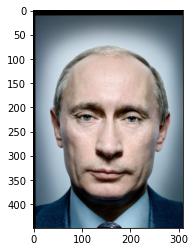

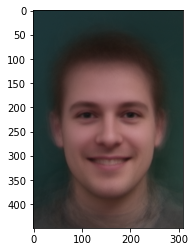

In [117]:
%matplotlib inline
plt.imsave("putin_align.jpg", im1_aligned)
putin = io.imread('putin_align.jpg')/255.
plt.imsave("average_align.jpg", im2_aligned)
averageIm = io.imread('average_align.jpg')/255.
plt.imshow(im1_aligned)
plt.show()
plt.imshow(im2_aligned)
plt.show()

In [ ]:
%matplotlib qt
putin_points = point_selector(putin, 30)

# result that I got from my 30 pts.
# np.array([[194.59800627,  49.60125448],
#  [138.60248656,  65.40860215],
#  [ 98.68223566, 144.9811828 ],
#  [135.11951165, 231.51971326],
#  [194.33008513, 247.59498208],
#  [207.99406362, 270.10035842],
#  [283.01198477, 255.90053763],
#  [311.94746864, 242.50448029],
#  [365.26377688, 207.13888889],
#  [389.10875896, 147.12455197],
#  [368.47883065,  95.14784946],
#  [313.82291667,  60.85394265],
#  [280.06485215,  45.31451613],
#  [220.58635753,  29.23924731],
#  [333.38116039, 108.54390681],
#  [337.3999776, 148.46415771],
#  [334.18492384, 190.52777778],
#  [224.06933244,  81.21594982],
#  [212.28080197, 104.52508961],
#  [224.87309588, 128.37007168],
#  [234.25033602, 102.64964158],
#  [226.48062276, 169.36200717],
#  [212.01288082, 196.9578853 ],
#  [224.06933244, 219.7311828 ],
#  [234.51825717, 196.68996416],
#  [295.60427867, 150.87544803],
#  [287.83456541, 129.17383513],
#  [285.15535394, 175.52419355],
#  [224.06933244, 149.53584229],
#  [153.60607079, 146.58870968],
#  [  0.,           0.        ],
#  [  0.,         298.        ],
#  [447.,           0.        ],
#  [447.,         298.        ]])

In [29]:
%matplotlib qt
averageIm_points = point_selector(averageIm, 30)

# result that I got from my 30 pts.
# np.array([[191.97143817,  59.62544803],
#  [134.85226254,  66.18458781],
#  [106.70262097, 138.88172043],
#  [136.76534498, 228.79659498],
#  [178.8531586, 240.27508961],
#  [206.4562052,  263.50537634],
#  [277.24025538, 263.23207885],
#  [321.51444892, 238.08870968],
#  [358.40961022, 214.03853047],
#  [389.83882168, 153.09318996],
#  [357.58971774,  94.88082437],
#  [317.14168907,  66.4578853 ],
#  [275.32717294,  44.04749104],
#  [216.84150986,  30.38261649],
#  [305.93649194, 107.99910394],
#  [312.22233423, 153.09318996],
#  [304.84330197, 197.91397849],
#  [220.39437724,  84.7688172 ],
#  [209.73577509, 107.17921147],
#  [221.4875672,  130.13620072],
#  [227.50011201, 107.45250896],
#  [220.94097222, 175.77688172],
#  [208.91588262, 199.00716846],
#  [220.94097222, 223.60394265],
#  [231.05297939, 198.18727599],
#  [276.14706541, 153.09318996],
#  [269.86122312, 132.59587814],
#  [269.31462814, 177.41666667],
#  [219.84778226, 151.72670251],
#  [159.44903674, 148.17383513],
#  [  0.,           0.        ],
#  [  0.,         304.        ],
#  [444.,           0.        ],
#  [444.,         304.        ]])

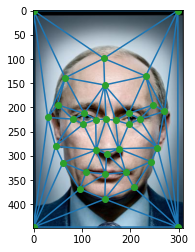

In [80]:
%matplotlib inline
plt.imshow(putin)
tri = Delaunay(putin_points)
plt.triplot(putin_points[:,1], putin_points[:,0], tri.simplices)
plt.plot(putin_points[:,1], putin_points[:,0], 'o')
plt.show()

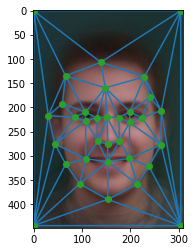

In [81]:
%matplotlib inline
plt.imshow(averageIm)
tri_avg = Delaunay(averageIm_points)
plt.triplot(averageIm_points[:,1], averageIm_points[:,0], tri_avg.simplices)
plt.plot(averageIm_points[:,1], averageIm_points[:,0], 'o')
plt.show()

In [ ]:
# The functions below are a bit touchy fyi

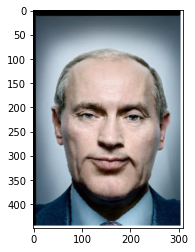

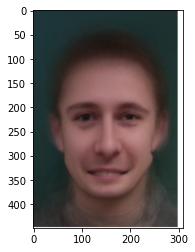

In [101]:
def mergeMorph(im1, im2, im_points1, im_points2):
    im_tri_1 = triangles(im_points1)
    face1 = np.ones(im1.shape)
    
    im_tri_2 = triangles(im_points2)
    face2 = np.ones(im2.shape)
    
    for tri in im_tri_1:
        im_pts1 = np.array(im_points1)[tri]
        im_pts2 = np.array(im_points2)[tri]
        
        alp = compute(im_pts2, im_pts1)
        rs_old, cs_old = polygon(np.array([im_pts2[0][0], im_pts2[1][0], im_pts2[2][0]]), 
                    np.array([im_pts2[0][1], im_pts2[1][1], im_pts2[2][1]]))
        rs_new, cs_new = application(rs_old, cs_old, alp)
        face1[rs_old, cs_old] = im1[rs_new, cs_new]
        
    for tri in im_tri_2:
        im_pts1 = np.array(im_points1)[tri]
        im_pts2 = np.array(im_points2)[tri]
        
        alp = compute(im_pts1, im_pts2)
        rs_old, cs_old = polygon(np.array([im_pts1[0][0], im_pts1[1][0], im_pts1[2][0]]), 
                    np.array([im_pts1[0][1], im_pts1[1][1], im_pts1[2][1]]))
        rs_new, cs_new = application(rs_old, cs_old, alp)
        face2[rs_old, cs_old] = im2[rs_new, cs_new]
    
    plt.imshow(face1)
    plt.show()
    plt.imshow(face2)
    plt.show()
    return face1, face2

putin_men, men_putin = mergeMorph(putin, averageIm, putin_points, averageIm_points)
plt.imsave("putin_men.jpg", putin_men)
plt.imsave("men_putin.jpg", men_putin)

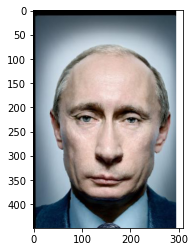

In [106]:
def morphCaricture(im, im_points1, im_points2, a):
    new_im_points2 = (im_points1 - im_points2) * a + im_points1
    im_tri = triangles(im_points1)
    face = np.ones(im.shape)
    
    for tri in im_tri:
        im_pts1 = np.array(im_points1)[tri]
        im_pts2 = np.array(new_im_points2)[tri]
        alp = compute(im_pts2, im_pts1)
        rr, cc = polygon(np.array([im_pts2[0][0], im_pts2[1][0], im_pts2[2][0]]), 
                    np.array([im_pts2[0][1], im_pts2[1][1], im_pts2[2][1]]))
        rr_new, cc_new = application(rr, cc, alp)
        face[rr, cc] = im[rr_new, cc_new]
    plt.imshow(face)
    plt.show()
    return face
face = morphCaricture(putin, np.array(putin_points), np.array(averageIm_points), 0.5)
plt.imsave("putin_caricatures.jpg", face)

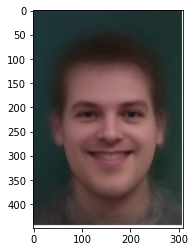

In [105]:
face_c = morphCaricture(averageIm, np.array(averageIm_points), np.array(putin_points), 0.5)
plt.imsave("mean_caricatures.jpg", face_c)